## Introduction to Custom Gradient Descent in Tensorflow 2.0

This is intended to be a introduction to the concept of gradient descent and linear regression, targeted to less-technical readers.  However, it is also the first and simplest example of performing gradient descent with Tensorflow 2.0.  Ever since the 2.0 release in September 2019 and native Keras integration, Tensorflow has become dramatically more accessible.

Even if you already know what gradient descent is, you will see at the end how to use Tensorflow's auto-differentiation to implement it in a few lines of code.


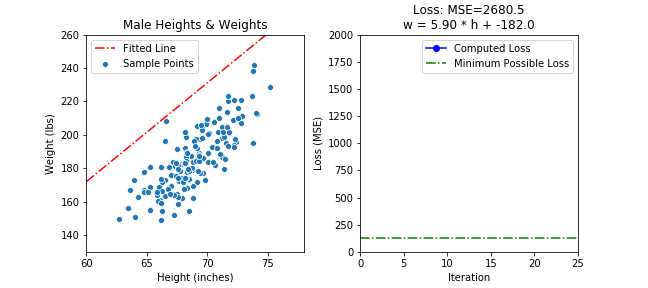

In [174]:
# Using IPython display module
from IPython.display import Image
Image('anim_1.gif')

-----

In [175]:
import os
import shutil
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import sklearn
from tensorflow import keras

from IPython.display import display, Image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

print(f'Using Python  = {sys.version.split()[0]}')
print(f'Tensorflow    = {tf.__version__}')
print(f'Keras Version = {keras.__version__}')

# This disables CUDA/GPU for this notebook
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

Using Python  = 3.7.2
Tensorflow    = 2.1.0
Keras Version = 2.2.4-tf


In [176]:
df = pd.read_csv('height_v_weight.csv')
df = df.drop(labels=' Gender', axis=1)
df.head(5)

,Height,Weight
0,73.847017,241.893563
1,68.781904,162.310473
2,74.110105,212.740856
3,71.730978,220.042470
4,69.881796,206.349801


In [177]:
def calc_mean_sq_error(df, slope, intercept):
    """
    Calculates mean-squared-error (MSE) of the line as a predictor of weights
    """
    hs, ws = df['Height'].values, df['Weight'].values
    diffs = (slope * hs + intercept) - ws
    mse = np.mean(diffs**2) 
    return mse
    
    
def draw_scatter(df, slope=None, intercept=None, ax=None):
    if ax is None:
        _,ax = plt.subplots(figsize=(4,4))
        
    sns.scatterplot(df['Height'], df['Weight'], ax=ax, label='Sample Points')
    ax.set_xlabel('Height (inches)')
    ax.set_ylabel('Weight (lbs)')
    ax.set_title('Male Height vs. Weight Sample')
    
    # For this exercise we're going to hardcode various parameters for simplicity
    h0,h1 = 60, 78
    w0,w1 = 130, 260
    ax.set_xlim(h0, h1)
    ax.set_ylim(w0, w1)
    ax.set_aspect((h1-h0)/(w1-w0))
    
    if slope is not None and intercept is not None:
        pred_w0, pred_w1 = (slope*h0 + intercept, slope*h1 + intercept)
        ax.plot([h0, h1], [pred_w0, pred_w1], 'r-.', label='Fitted Line')
        mse = calc_mean_sq_error(df, slope, intercept)
        eqn_str = f'w = {slope:.2f} * h + {intercept:.1f}'
        ax.set_title(f'Loss: MSE={mse:.1f}\n{eqn_str}')
        
    ax.legend(loc='upper left')
    return ax

Mean squared error looks like this

$w_{i,pred} = \alpha \cdot h_i + \beta$

$MSE = \frac{1}{N}\sum_{i=1}^{N} (w_{i,true} - w_{i,pred})^2$

$MSE = \frac{1}{N}\sum_{i=1}^{N} (w_{i,true} - (\alpha * h_i + \beta))^2$

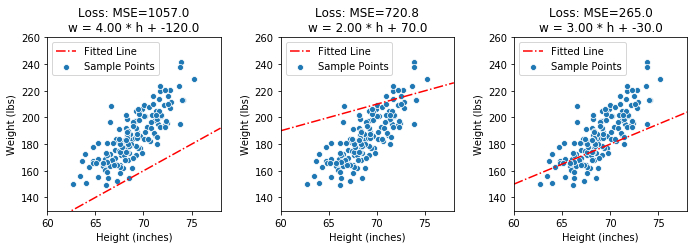

In [178]:
fig, axs = plt.subplots(1, 3, figsize=(10,5))
draw_scatter(df, slope=4,  intercept = -120, ax=axs[0])
draw_scatter(df, slope=2,  intercept =   70, ax=axs[1])
draw_scatter(df, slope=3,  intercept =  -30, ax=axs[2])
plt.tight_layout(2)

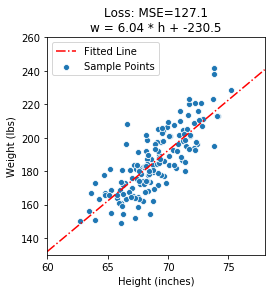

In [179]:
# Let's find the analytical solution using sklearn
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(df['Height'].values.reshape([-1, 1]), df['Weight'].values)

# Let's look at the optimal model parameters and its optimal MSE loss
true_slope, true_intercept = lin_reg.coef_[0], lin_reg.intercept_
min_mse = calc_mean_sq_error(df, true_slope, true_intercept)

_ = draw_scatter(df, slope=true_slope, intercept=true_intercept)

## Using Tensorflow and Gradient Descent

For such a simple problem with an analytical solution, we don't need to use gradient descent.  But the goal here is to introduce Tensorflow's auto-differentiation feature on a simple problem to get a feel for the its mechanics without complexity.  We'll also see that it comes to reasonable solutions even if they are not actually optimal.

In [180]:
def tf_calc_mse_verbose(heights, weights, slope, intercept):
    """
    This method is basically identical to calc_mse() from before, but we
    need to use only operations defined on tensors and tf.* methods.
    """
    predictions = tf.add(tf.multiply(slope, heights), intercept)
    errors = tf.subtract(predictions, weights)
    mse = tf.reduce_mean(tf.square(errors))
    return mse
    
def tf_calc_mse_clean(heights, weights, slope, intercept):
    """
    Tensor algebra can be implemented with standard operators, simplifying
    the expressions.  This method is identical to the one above.
    """
    predictions = slope * heights + intercept
    errors = predictions - weights
    mse = tf.reduce_mean(errors**2)
    return mse

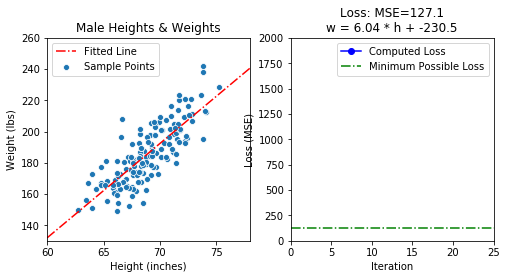

In [181]:
def draw_linreg_progress(df, slope, intercept, mse_hist, min_mse, file_out=None, n_iter=25, fig=None, axs=None):
    if fig is None or axs is None:
        fig, axs = plt.subplots(1, 2, figsize=(8,4))
        
    draw_scatter(df, slope, intercept, ax=axs[0])
    
    # Draw loss-chart.  Hardcode a few more parameters for simplicity
    hmin, hmax = 0, n_iter
    wmin, wmax = 0, 2000
    axs[1].plot(range(len(mse_hist)), mse_hist, 'b-', marker='o', label='Computed Loss')
    axs[1].plot([hmin, hmax], [min_mse, min_mse], 'g-.', label='Minimum Possible Loss')
    axs[1].set_xlim(hmin, hmax)
    axs[1].set_ylim(wmin, wmax)
    axs[1].set_xlabel('Iteration')
    axs[1].set_ylabel('Loss (MSE)')
    axs[1].legend(loc='upper right')
    axs[1].set_aspect(hmax/float(wmax))
    
    # Update the axis titles
    mse = calc_mean_sq_error(df, slope, intercept) if len(mse_hist)==0 else mse_hist[-1]
    axs[0].set_title('Male Heights & Weights')
    eqn_str = f'w = {slope:.2f} * h + {intercept:.1f}'
    axs[1].set_title(f'Loss: MSE={mse:.1f}\n{eqn_str}')
    #plt.tight_layout(3.0)
    
    if file_out:
        fig.savefig(file_out)
        
    return fig, axs
    
_ = draw_linreg_progress(df, true_slope, true_intercept, [], min_mse)

In [182]:
def run_gradient_descent(df, init_slope, init_icept, n_iter=25, learning_rate=2e-5, dir_name=None):
    """
    Provide initial estimate of slope and intercept, gradient descent will fine-tune
    it and provide a near-optimal solution
    """
    
    # Data vectors don't need to be tensors, since they are static
    Hs, Ws = df['Height'].values, df['Weight'].values
    
    # Only need to convert variables which will be part of gradient calcs
    tf_slope = tf.Variable(init_slope, dtype='float32') 
    tf_icept = tf.Variable(init_icept, dtype='float32') 
    
    # Use this to accumulate loss values after each iteration
    loss_hist = []
    shutil.rmtree(dir_name, ignore_errors=True)
    
    fig, axs = plt.subplots(1, 2, figsize=(9,4))
    
    for i in range(n_iter):
        
        # tf.GradientTape() tracks all differentiable tensor calcs within the block
        with tf.GradientTape() as tape:
            # Tell the tape that we want to track the slope and intercept
            tape.watch((tf_slope, tf_icept))

            # Compute the loss within the gradient tape
            predictions = tf_slope * Hs + tf_icept
            errors = predictions - Ws
            loss = tf.reduce_mean(errors**2)

        #########################################################################
        # Magic!  Derivative of loss value w.r.t. model parameters
        dloss_dparams = tape.gradient(loss, [tf_slope, tf_icept])
        #########################################################################

        # Since we didn't normalize, and slope has different characteristic than
        # intercept, we have to magnify the icept gradients or else only slope adjusts
        tf_slope = tf_slope - learning_rate * dloss_dparams[0]
        tf_icept = tf_icept - learning_rate * dloss_dparams[1] * 1000.0
            
        # Aggregate and plot loss-values before doing more math 
        loss_hist.append(loss)
        if dir_name:
            os.makedirs(dir_name, exist_ok=True)
            fout = os.path.join(dir_name, f'img_{i:03d}.png')
            axs[0].clear()
            axs[1].clear()
            draw_linreg_progress(df, tf_slope, tf_icept, loss_hist, min_mse, n_iter=n_iter, file_out=fout, fig=fig, axs=axs)
        
    return tf_slope.numpy(), tf_icept.numpy(), loss_hist[-1]
        

### ***Let's see how well it works!***

It turns out the loss surface is a bit wilder than you would expect, especially since we didn't normalize our data beforehand.  While this should theoretically still work, we end up needing some super-dynamic, per-parameter learning rates to get it to work from arbitrarily chosen initial values.

To avoid over-complicating this, we will simply run it a couple times from a reasonable initial guess of the parameters, and let it fine-tune the answer for us.  In most gradient descent problems.

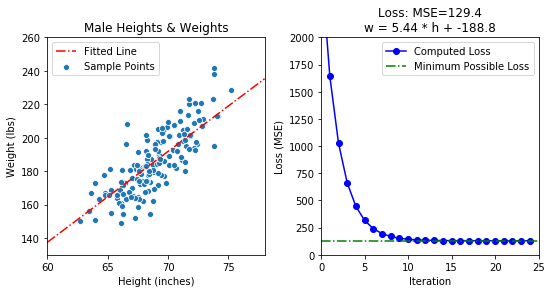

In [183]:
slope1, int1, loss1 = run_gradient_descent(df, true_slope, -180, dir_name='imgs_descent_1')

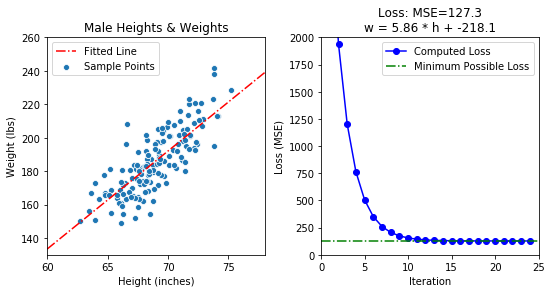

In [184]:
slope2, int2, loss2 = run_gradient_descent(df, 5.0, true_intercept, dir_name='imgs_descent_2')

### Make looping .gif animations
The above methods wrote out all the figures to local directories.  Can use locally-installed imagemagick to convert them to animations.  Expect these cells to fail if you are not in Linux or you don't have imagemagick installed.

In [185]:
import subprocess
try:
    subprocess.check_output(['convert', 'imgs_descent_1/*', '-loop', '0', '-delay','50', 'anim_1.gif'])
    subprocess.check_output(['convert', 'imgs_descent_2/*', '-loop', '0', '-delay','50', 'anim_2.gif'])
except Exception as e:
    print(f'Failed to create .gif files.  Only works on Linux with "imagemagick" installed')
    print(f'Error: {str(e)}')
    

Converged slope = 5.44, intercept = -188.81, final MSE=129.4


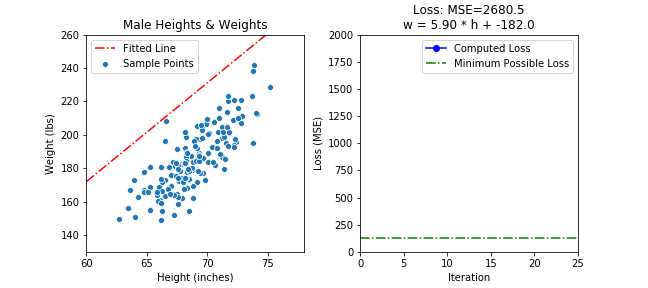

In [186]:
print(f'Converged slope = {slope1:.2f}, intercept = {int1:.2f}, final MSE={loss1:.1f}')
Image('anim_1.gif')

Converged slope = 5.86, intercept = -218.09, final MSE=127.3


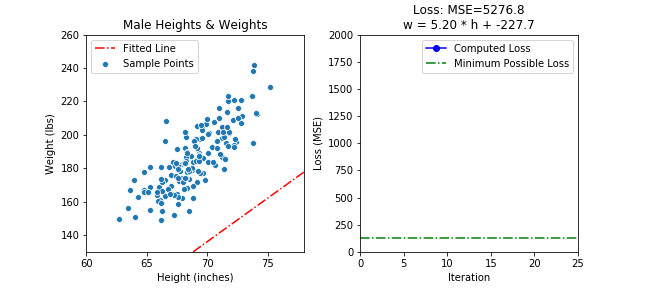

In [187]:
print(f'Converged slope = {slope2:.2f}, intercept = {int2:.2f}, final MSE={loss2:.1f}')
Image('anim_2.gif')

In [188]:
print('----')
print(f'Exact solution: slope = {true_slope:.2f}, intercept = {true_intercept:.2f}, final MSE={min_mse:.1f}')
print('----')
print(f'Grad Descent 1: slope = {slope1:.2f}, intercept = {int1:.2f}, final MSE={loss1:.1f}')
print(f'Grad Descent 2: slope = {slope2:.2f}, intercept = {int2:.2f}, final MSE={loss2:.1f}')
print('----')

----
Exact solution: slope = 6.04, intercept = -230.53, final MSE=127.1
----
Grad Descent 1: slope = 5.44, intercept = -188.81, final MSE=129.4
Grad Descent 2: slope = 5.86, intercept = -218.09, final MSE=127.3
----


We see that gradient descent did not converge to the exact solution, as we get substantially different slopes and intercepts.  But looking at the MSE values, they're actually quite close to optimal.  It turns out that with least-squares regression, there are a lot of slopes and intercepts that produce near-optimal solutions.  In this case, it is a combination of:

* Since we're so close to an optimal solution already, gradients are tiny so iterative updates make very little difference
* We didn't normalize our data, and the slope and intercept parameters also have different characteristics.  Tiny changes in slope change the loss dramatically, while tiny changes in intercept have very little effect.  So gradient descent ends up primarily optimizing slope staying very close to our initial intercept guess.  Normalizing the data would have dramatically improved this phenomenon.

-----

### Upload the .gif files to make sure they are up to date for the blog post

I could look really smart and use boto3 library, but it seems like overkill.  AWSCLI commands are appropriate here.

In [198]:
!aws s3 cp anim_1.gif s3://areiner-toptal-blog-resources/tf_gd_intro/ --acl public-read
!aws s3 cp anim_2.gif s3://areiner-toptal-blog-resources/tf_gd_intro/ --acl public-read

upload: ./anim_1.gif to s3://areiner-toptal-blog-resources/tf_gd_intro/anim_1.gif
upload: ./anim_2.gif to s3://areiner-toptal-blog-resources/tf_gd_intro/anim_2.gif


-----

## Final Thoguhts:  Using Optimizers
Below we implement the same gradient descent code but using an optimizer instead of manually applying gradients.  This is the pattern that we should generally use for performing gradient descent, though we will see in that there is no universally-best optimizer.  You have to try different optimizers for each problem.

In [190]:
def run_gradient_descent_w_opt(df, init_slope, init_icept, optimizer, n_iter=25, dir_name=None):
    """
    Provide initial estimate of slope and intercept, gradient descent will fine-tune
    it and provide a near-optimal solution
    """
    
    # Data vectors don't need to be tensors, since they are static
    Hs, Ws = df['Height'].values, df['Weight'].values
    
    # Only need to convert variables which will be part of gradient calcs
    tf_slope = tf.Variable(init_slope, dtype='float32') 
    tf_icept = tf.Variable(init_icept, dtype='float32') 
    trainable_params = (tf_slope, tf_icept)
    
    # Use this to accumulate loss values after each iteration
    loss_hist = []
    shutil.rmtree(dir_name, ignore_errors=True)
    
    fig, axs = plt.subplots(1, 2, figsize=(9,4))
    
    for i in range(n_iter):
        
        # tf.GradientTape() tracks all differentiable tensor calcs within the block
        with tf.GradientTape() as tape:
            # Tell the tape that we want to track the slope and intercept
            tape.watch(trainable_params)

            # Compute the loss within the gradient tape
            predictions = tf_slope * Hs + tf_icept
            errors = predictions - Ws
            loss = tf.reduce_mean(errors**2)

        #########################################################################
        # Magic!  Derivative of loss value w.r.t. model parameters
        dloss_dparams = tape.gradient(loss, trainable_params)
        #########################################################################

        # The following two commented lines are the original, manual gradient ops
        #tf_slope = tf_slope - learning_rate * dloss_dparams[0]
        #tf_icept = tf_icept - learning_rate * dloss_dparams[1] * 1000.0
        
        # Instead we now let the optimizer do it for us. The apply_gradients()
        # method assumes this is a minimization problem and gradients are positive.
        optimizer.apply_gradients(zip(dloss_dparams, trainable_params))
            
        # Aggregate and plot loss-values before doing more math 
        loss_hist.append(loss)
        if dir_name:
            os.makedirs(dir_name, exist_ok=True)
            fout = os.path.join(dir_name, f'img_{i:03d}.png')
            axs[0].clear()
            axs[1].clear()
            draw_linreg_progress(df, tf_slope.numpy(), tf_icept.numpy(),
                                 loss_hist, min_mse, file_out=fout,
                                 n_iter=n_iter, fig=fig, axs=axs)
        
    return tf_slope.numpy(), tf_icept.numpy(), loss_hist[-1]
        

### Try the RMSprop optimizer first

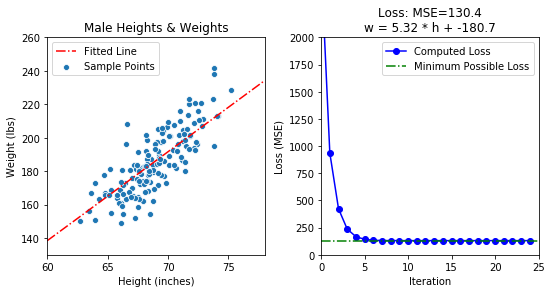

In [191]:
opt = keras.optimizers.RMSprop(learning_rate=0.1)
slope3, int3, loss3 = run_gradient_descent_w_opt(df, true_slope, -180, optimizer=opt, dir_name='imgs_descent_3')

In [192]:
import subprocess
try:
    subprocess.check_output(['convert', 'imgs_descent_3/*', '-loop', '0', '-delay','50', 'anim_3.gif'])
except Exception as e:
    print(f'Failed to create .gif files.  Only works on Linux with "imagemagick" installed')
    print(f'Error: {str(e)}')
    

Converged slope = 5.32, intercept = -180.74, final MSE=130.4


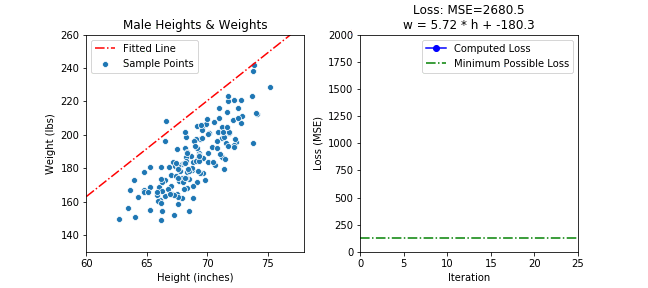

In [193]:
print(f'Converged slope = {slope3:.2f}, intercept = {int3:.2f}, final MSE={loss3:.1f}')
Image('anim_3.gif')

RMSprop looks great.  Let's look at Adam() because an interesting phenomenon happens.


### Next we try the Adam optimizer

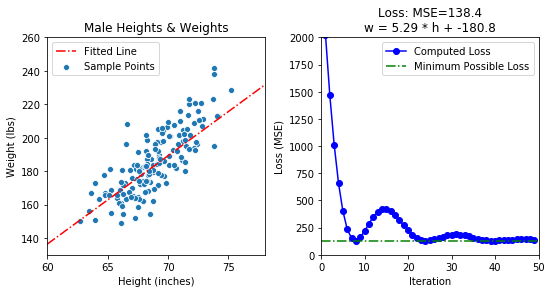

In [194]:
opt = keras.optimizers.Adam(learning_rate=0.1)
slope4, int4, loss4 = run_gradient_descent_w_opt(df, true_slope, -180, optimizer=opt, dir_name='imgs_descent_4', n_iter=50)

In [195]:
import subprocess
try:
    subprocess.check_output(['convert', 'imgs_descent_4/*', '-loop', '0', '-delay','50', 'anim_4.gif'])
except Exception as e:
    print(f'Failed to create .gif files.  Only works on Linux with "imagemagick" installed')
    print(f'Error: {str(e)}')
    

Converged slope = 5.29, intercept = -180.77, final MSE=138.4


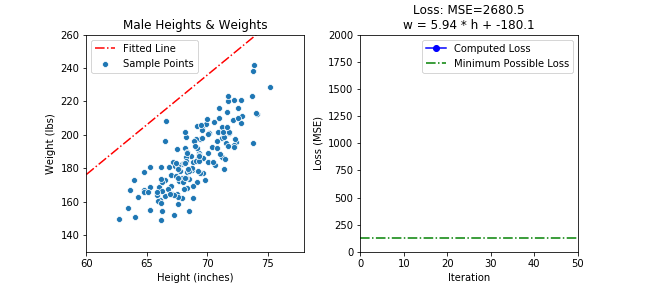

In [196]:
print(f'Converged slope = {slope4:.2f}, intercept = {int4:.2f}, final MSE={loss4:.1f}')
Image('anim_4.gif')

## What happened here?

We observe what is likely the effect of a momentum feature of this particular optimizer.  It adds values of previous gradients to the current gradient, in order to smooth out the motion for complex surfaces.  But for this problem, it actually hurts us by overshooting the local minimum and having to reverse multiple times.


This should reinforce the notion that there is no one optimizer is universally better than any other.  When you use optimizers, you should make the choice of optimizer one of the hyperparameters to tune.

In [197]:
!aws s3 cp anim_3.gif s3://areiner-toptal-blog-resources/tf_gd_intro/ --acl public-read
!aws s3 cp anim_4.gif s3://areiner-toptal-blog-resources/tf_gd_intro/ --acl public-read

upload: ./anim_3.gif to s3://areiner-toptal-blog-resources/tf_gd_intro/anim_3.gif
upload: ./anim_4.gif to s3://areiner-toptal-blog-resources/tf_gd_intro/anim_4.gif
